## Importação de pacotes


In [40]:
from backend import (frequency_dfg, partition_dataframe_into_dfgs,
                     get_dataframe, get_start_end_activities, dfg_type,
                     ACTIVITY_NAME, CASE_CONCEPT_NAME, TIMESTAMP_NAME)
from math import floor, ceil
import polars as pl
import pm4py

In [10]:
from functools import reduce

def get_activities_from_dfg(dfg):
    return set(reduce(lambda x, y: x + y, dfg.keys(), tuple()))

def filter_dict_by_dfg(dic: dict[str, int], dfg: dfg_type):
    return {key: value for key, value in dic.items()
            if key in get_activities_from_dfg(dfg)}

def show_flowchart(filtered_df: pl.DataFrame, ea_dfg: dfg_type,
                   sa_dfg: dfg_type):
    jump_dfg = frequency_dfg(filtered_df, 30)
    filtered_ea_dfg = filter_dict_by_dfg(ea_dfg, jump_dfg)
    filtered_sa_dfg = filter_dict_by_dfg(sa_dfg, jump_dfg)
    pm4py.view_dfg(jump_dfg, filtered_sa_dfg, filtered_ea_dfg)

# Formatando o dataframe

In [3]:
df = get_dataframe("./data/civel_18006.csv")
sa_dfg, ea_dfg = get_start_end_activities(df)

/root/JuMP-Research/conformance/backend/eventlog.py:28: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  dataframe = dataframe.with_columns([


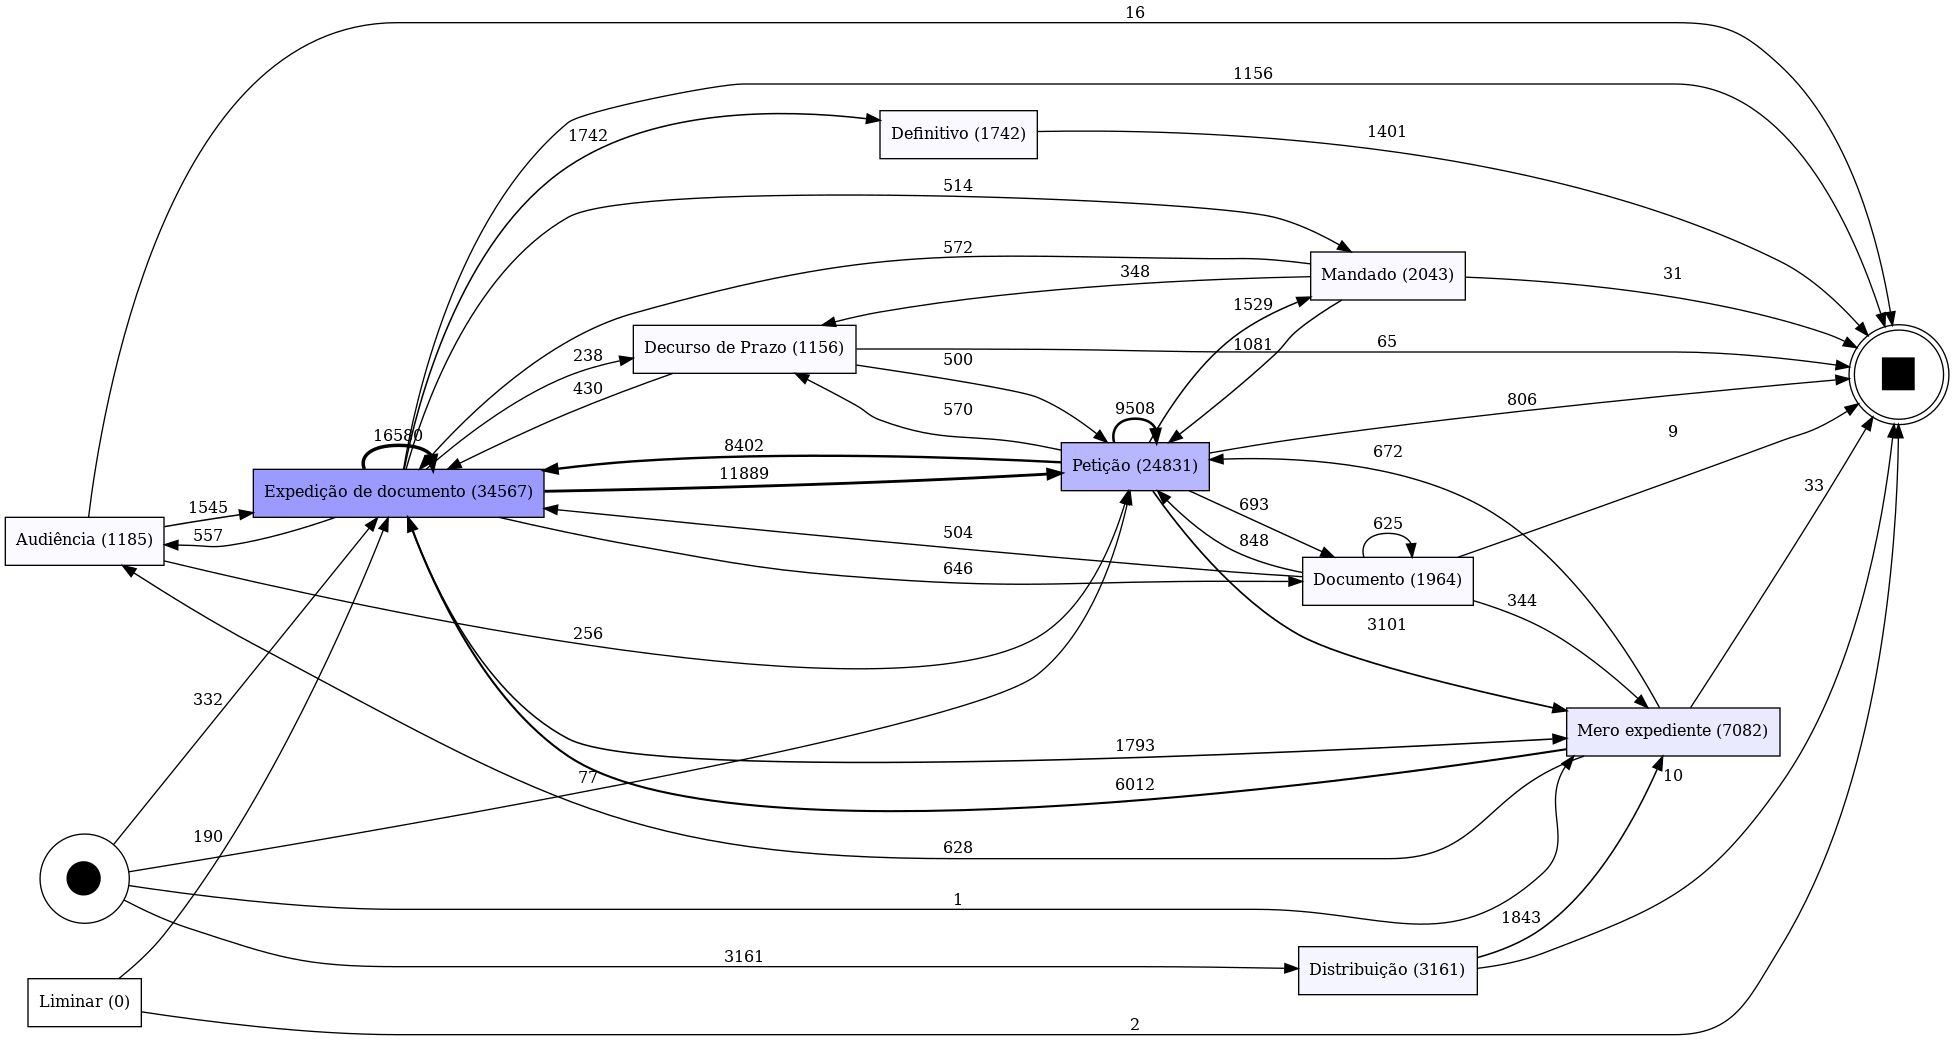

In [7]:
jump_dfg = frequency_dfg(df, 30)
filtered_ea_dfg = filter_dict_by_dfg(ea_dfg, jump_dfg)
filtered_sa_dfg = filter_dict_by_dfg(sa_dfg, jump_dfg)
pm4py.view_dfg(jump_dfg, filtered_sa_dfg, filtered_ea_dfg)

# Remoção por nº de ocorrências

A partir do número de ocorrências dos movimentos geral é removido os N movimentos mais frequentes.

In [8]:
activities_count = df[ACTIVITY_NAME].value_counts()
most_frequent = activities_count.sort("count", descending=True)[:3]
print(most_frequent)

shape: (3, 2)
┌────────────────────────┬───────┐
│ concept:name           ┆ count │
│ ---                    ┆ ---   │
│ str                    ┆ u32   │
╞════════════════════════╪═══════╡
│ Expedição de documento ┆ 37374 │
│ Petição                ┆ 28649 │
│ Mero expediente        ┆ 8779  │
└────────────────────────┴───────┘


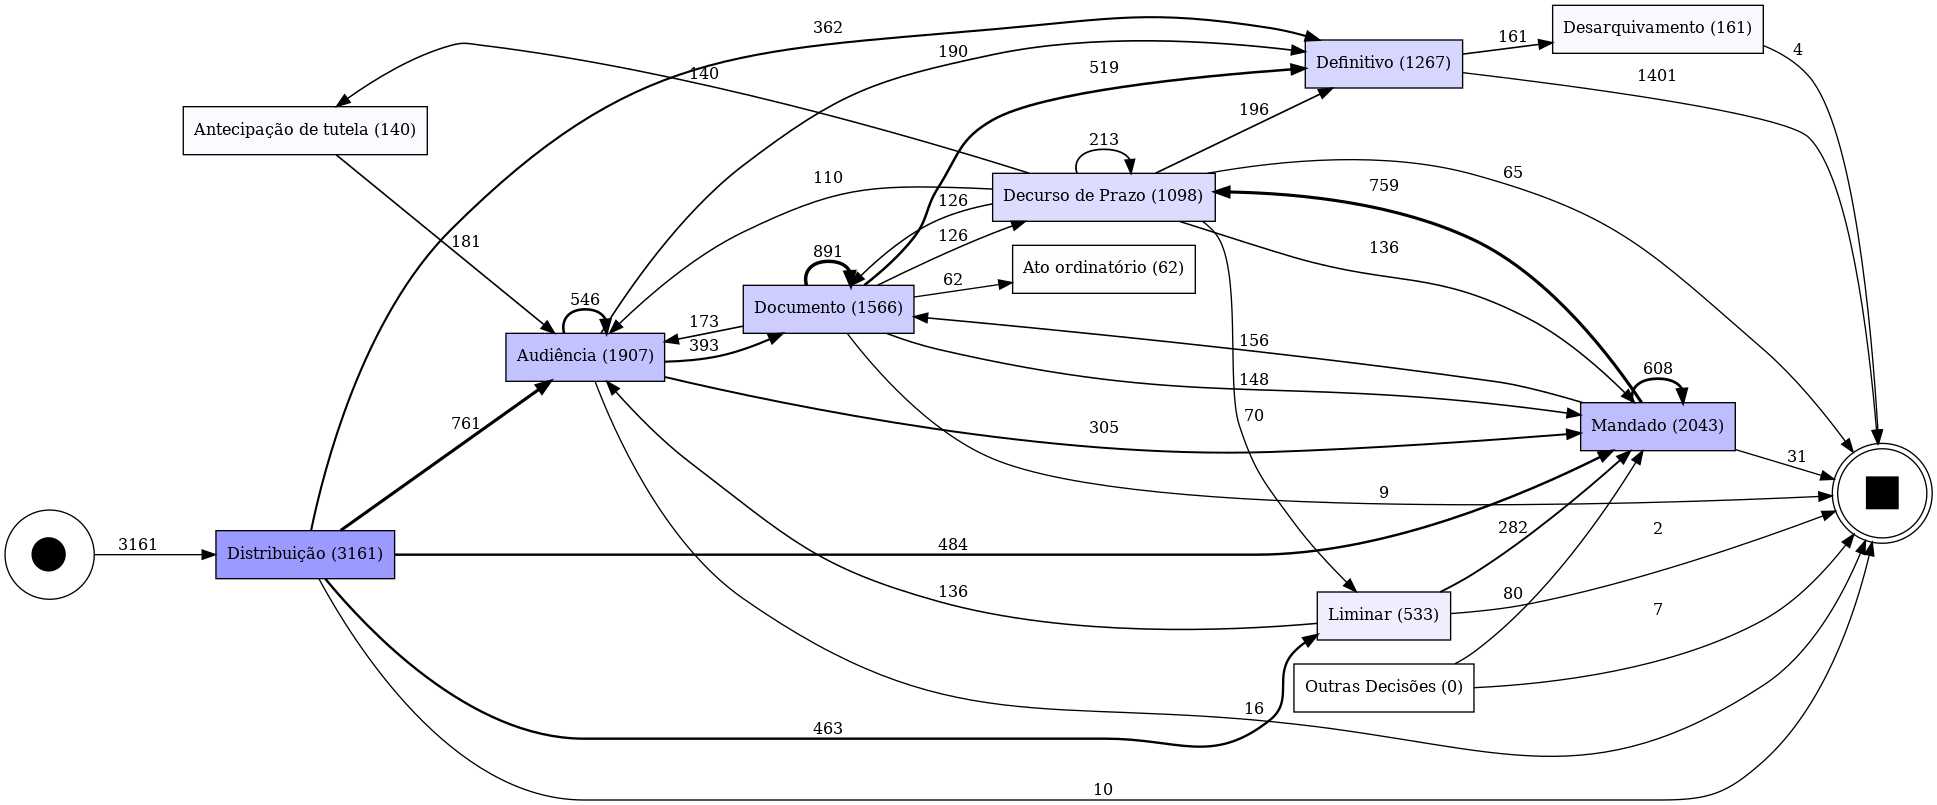

In [11]:
remove_list = most_frequent[ACTIVITY_NAME].to_list()
filtered_df = df.filter(~pl.col(ACTIVITY_NAME).is_in(remove_list))

show_flowchart(filtered_df, ea_dfg, sa_dfg)

# Remoção por nº de relações

A partir das relações de causalidade mais frequentes remove os movimentos das N relações mais frequentes.

In [31]:
from pprint import pprint

most_frequent = frequency_dfg(df, 8, percentage=0)
pprint(sorted(most_frequent.items(), key=lambda x: x[1], reverse=True))

[(('Expedição de documento', 'Expedição de documento'), 16580),
 (('Expedição de documento', 'Petição'), 12476),
 (('Petição', 'Petição'), 10787),
 (('Petição', 'Expedição de documento'), 8549),
 (('Mero expediente', 'Expedição de documento'), 6438),
 (('Petição', 'Mero expediente'), 3892),
 (('Expedição de documento', 'Mero expediente'), 2047),
 (('Audiência', 'Expedição de documento'), 1939)]


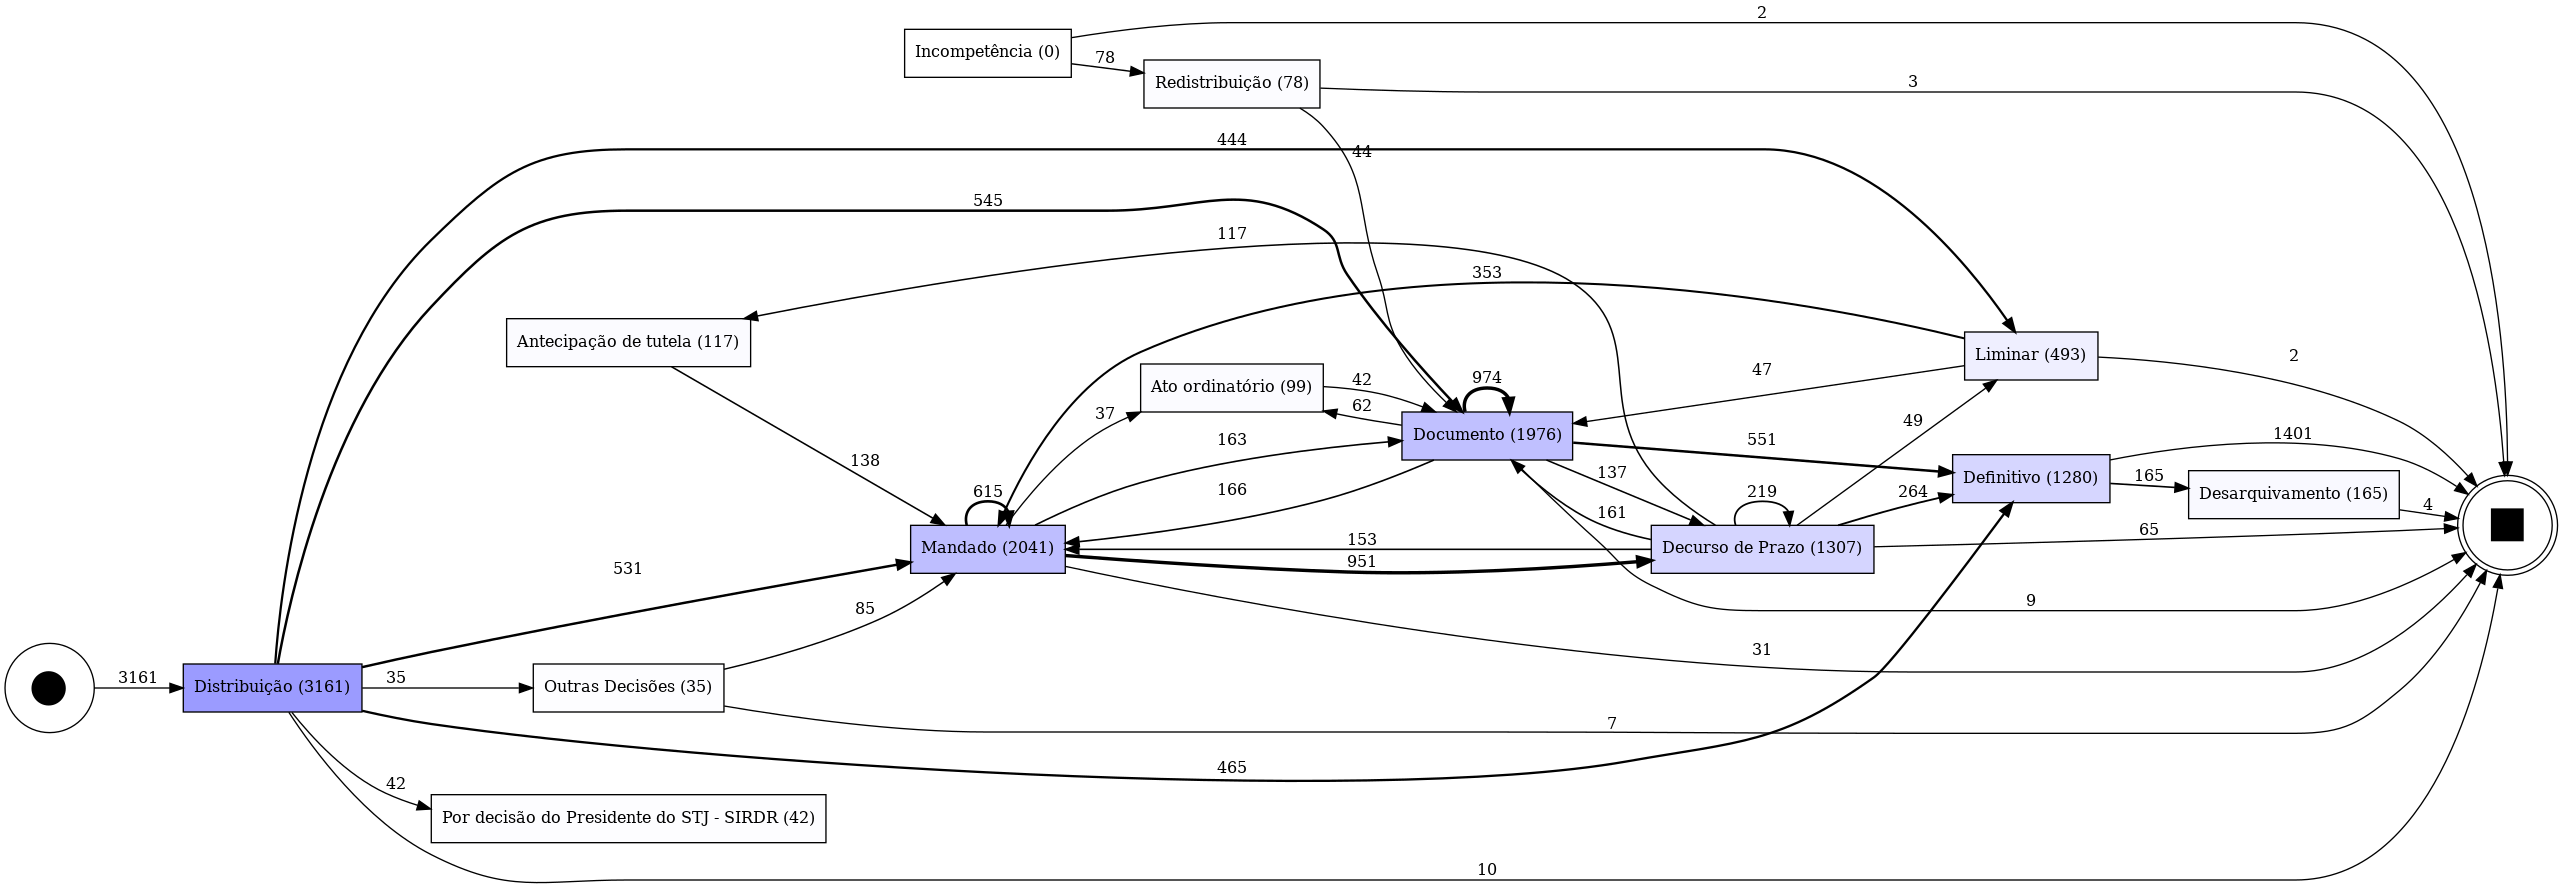

In [32]:
remove_list = get_activities_from_dfg(most_frequent)
filtered_df = df.filter(~pl.col(ACTIVITY_NAME).is_in(remove_list))

show_flowchart(filtered_df, ea_dfg, sa_dfg)

# Remoção por nº de ocorrências nas fases

Divide os processos dos logs em N fases e remove os movimentos que:
1. Aparecem nas N fases
2. Aparecem nas N fases com maior frequência (threshold/quantidade).

In [123]:
from collections import Counter

start_activities = list()
middle_activities = list()
end_activities = list()
for case, events in df.sort(TIMESTAMP_NAME).group_by(CASE_CONCEPT_NAME):
    activity_list = events[ACTIVITY_NAME].to_list()
    side_amount = ceil(len(case) * 0.25)

    start = activity_list[:side_amount]
    middle = activity_list[side_amount:-side_amount]
    end = list()
    if len(activity_list) > 1:
        end = activity_list[-side_amount:]
    
    start_activities.extend(start)
    middle_activities.extend(middle)
    end_activities.extend(end)

/tmp/ipykernel_26643/1866179850.py:28: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['case:concept:name'])`.
  for case, events in df.sort(TIMESTAMP_NAME).group_by(CASE_CONCEPT_NAME):


In [127]:
frequent_sa = Counter(start_activities).most_common(5)
frequent_ma = Counter(middle_activities).most_common(5)
frequent_ea = Counter(end_activities).most_common(5)

pprint((frequent_sa, frequent_ma, frequent_ea))

([('Expedição de documento', 8947),
  ('Petição', 4910),
  ('Mero expediente', 3574),
  ('Distribuição', 3222),
  ('Documento', 1002)],
 [('Expedição de documento', 18273),
  ('Petição', 18161),
  ('Mero expediente', 4200),
  ('Mandado', 1575),
  ('Documento', 1524)],
 [('Expedição de documento', 12126),
  ('Petição', 6389),
  ('Definitivo', 1819),
  ('Mero expediente', 1522),
  ('Documento', 659)])


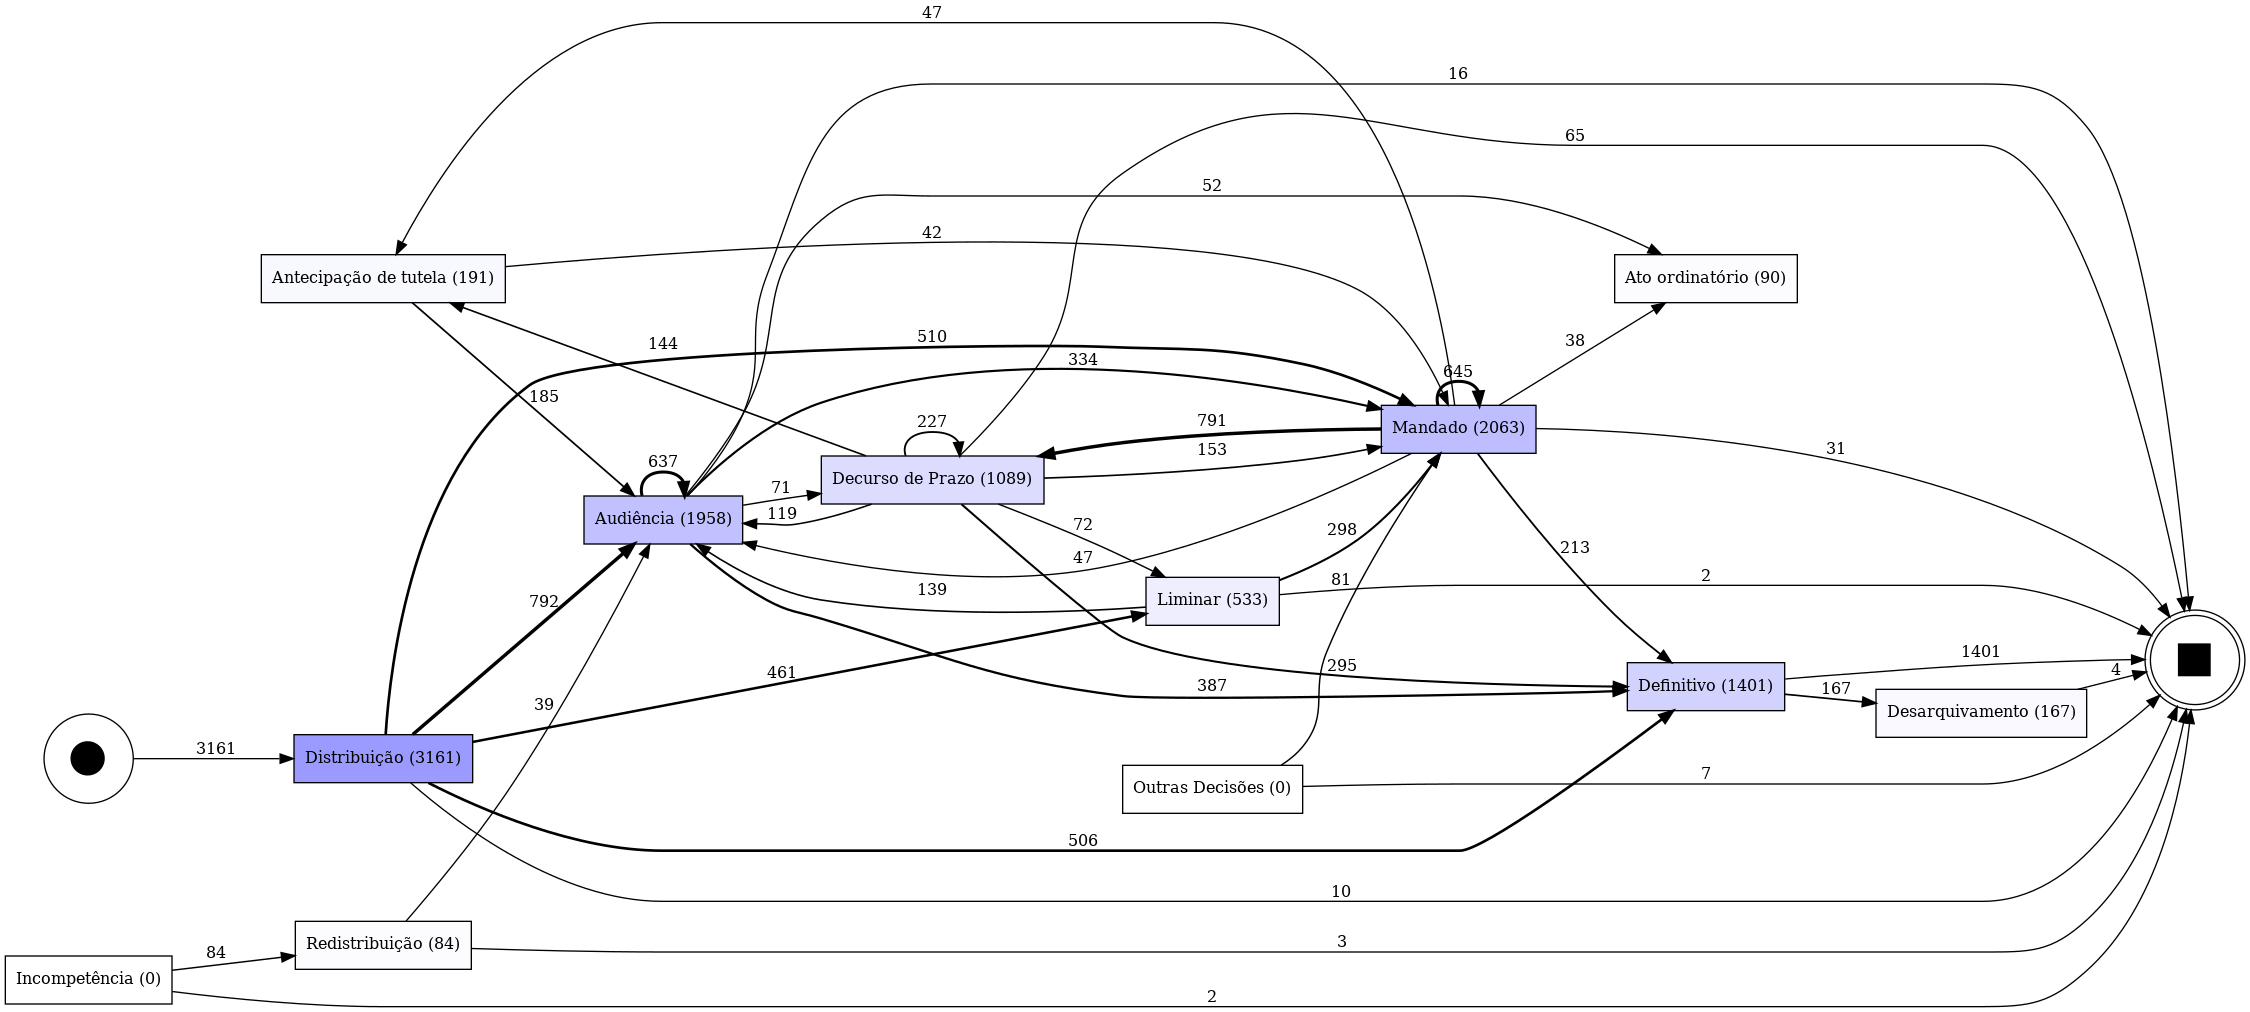

In [131]:
remove_list = set(dict(frequent_sa).keys()).intersection(
    dict(frequent_ma).keys(), dict(frequent_ea).keys())
filtered_df = df.filter(~pl.col(ACTIVITY_NAME).is_in(remove_list))

show_flowchart(filtered_df, ea_dfg, sa_dfg)

# Remoção por n° de relações por fases

Divide as relações de causalidade do log em N fases e remove os movimentos que:
1. Aparecem nas N fases
2. Aparecem nas N fases com maior frequência (threshold/quantidade).

In [135]:
start, middle, end = partition_dataframe_into_dfgs(df, ACTIVITY_NAME, 0.25)

COUNT_THRESH = 5
frequent_sa_dfg = Counter(start).most_common(COUNT_THRESH)
frequent_ma_dfg = Counter(middle).most_common(COUNT_THRESH)
frequent_ea_dfg = Counter(end).most_common(COUNT_THRESH)

pprint((frequent_sa_dfg, frequent_ma_dfg, frequent_ea_dfg))

([(('Expedição de documento', 'Expedição de documento'), 4054),
  (('Expedição de documento', 'Petição'), 2478),
  (('Mero expediente', 'Expedição de documento'), 2304),
  (('Petição', 'Petição'), 2112),
  (('Distribuição', 'Mero expediente'), 1854)],
 [(('Expedição de documento', 'Expedição de documento'), 6430),
  (('Expedição de documento', 'Petição'), 6388),
  (('Petição', 'Petição'), 6267),
  (('Petição', 'Expedição de documento'), 4289),
  (('Mero expediente', 'Expedição de documento'), 2769)],
 [(('Expedição de documento', 'Expedição de documento'), 6096),
  (('Expedição de documento', 'Petição'), 3610),
  (('Petição', 'Expedição de documento'), 3309),
  (('Petição', 'Petição'), 2408),
  (('Expedição de documento', 'Definitivo'), 1651)])


In [137]:
frequent_sa = get_activities_from_dfg(dict(frequent_sa_dfg))
frequent_ma = get_activities_from_dfg(dict(frequent_ma_dfg))
frequent_ea = get_activities_from_dfg(dict(frequent_ea_dfg))

remove_list = frequent_sa.intersection(frequent_ma, frequent_ea)
print(remove_list)

{'Expedição de documento', 'Petição'}


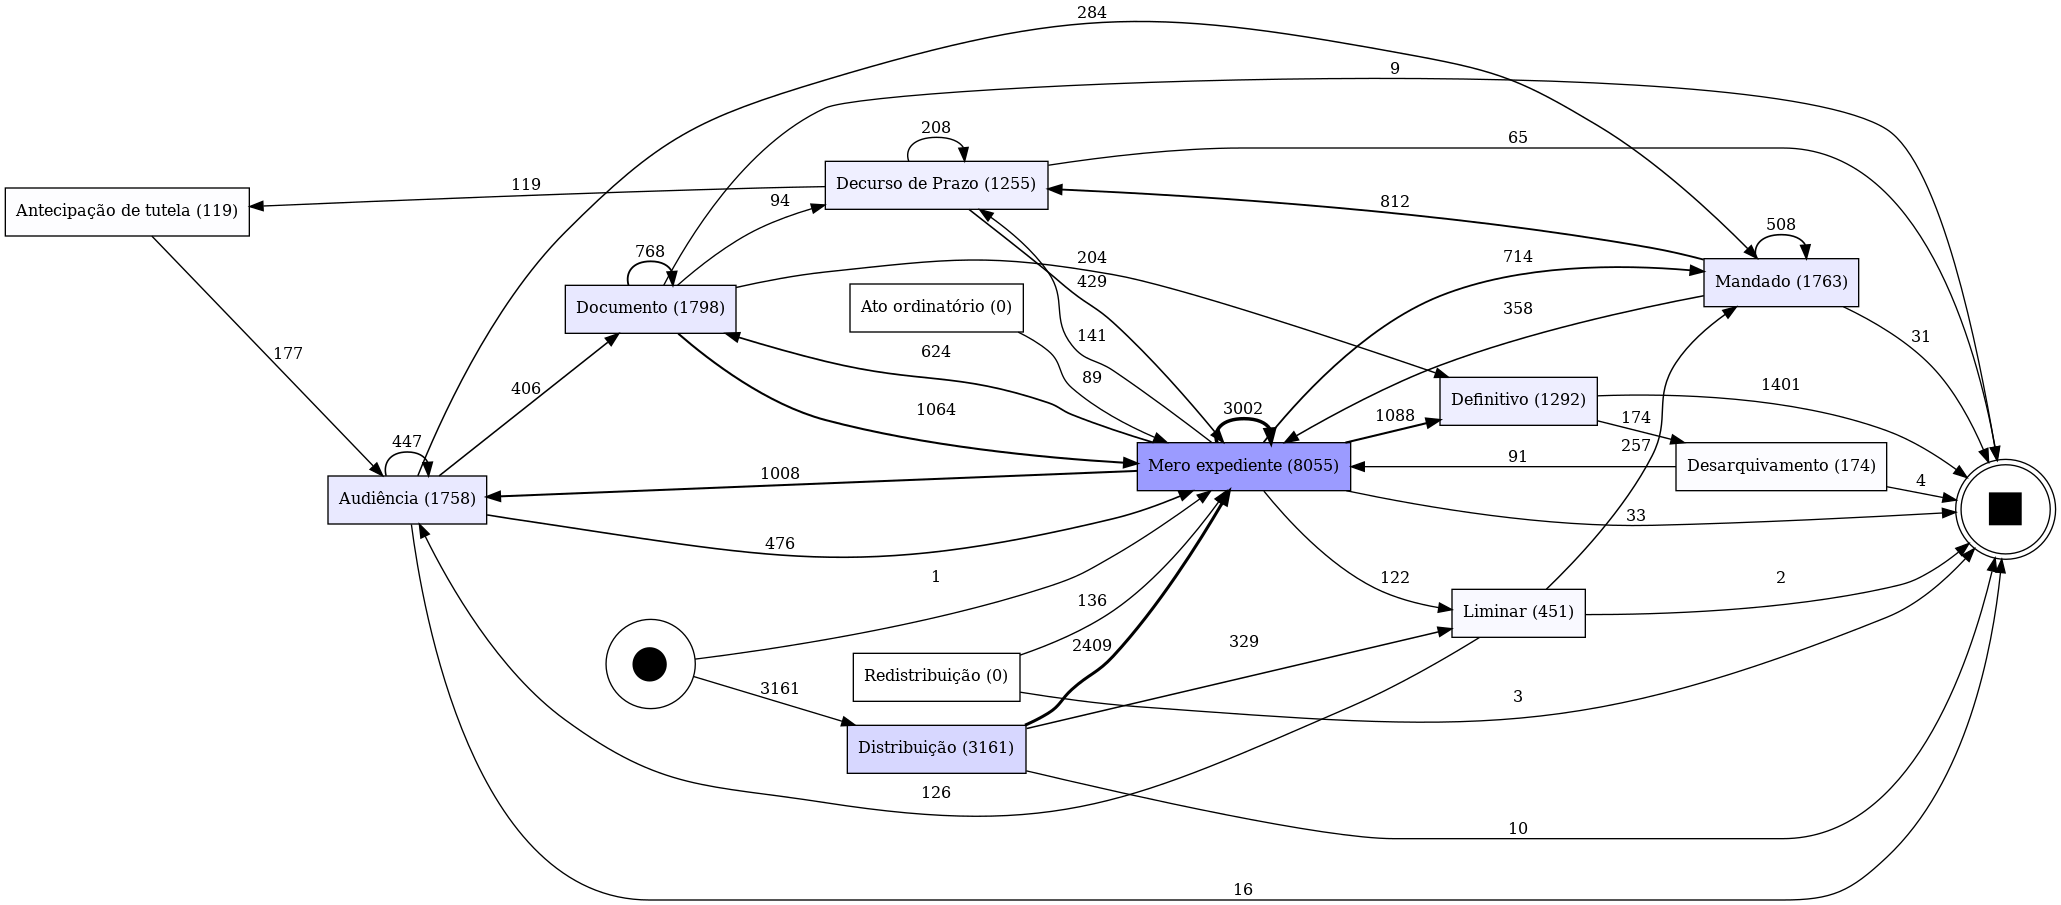

In [138]:
filtered_df = df.filter(~pl.col(ACTIVITY_NAME).is_in(remove_list))

show_flowchart(filtered_df, ea_dfg, sa_dfg)

# Remoção por força de dependência

In [139]:
def get_dependency_matrix(dfg: dfg_type) -> dfg_type:
    dependency_matrix = dict()
    for (act1, act2), value in dfg.items():
        if act1 != act2:
            inv_couple = (act2, act1)
            c1 = value
            if inv_couple in dfg:
                c2 = dfg[inv_couple]
                dep = (c1 - c2) / (c1 + c2 + 1)
            else:
                dep = c1 / (c1 + 1)
        else:
            dep = value / (value + 1)
        dependency_matrix[(act1, act2)] = dep
    return dependency_matrix

In [167]:
from pm4py import discover_dfg

dfg, _, _ = discover_dfg(df.to_pandas())
dependency_dfg = get_dependency_matrix(dfg)

most_frequent = sorted(dependency_dfg.items(),
                       key=lambda x: x[1],
                       reverse=True)[:100]
sum_items = lambda x, y: x + y[0] 
most_frequent = Counter(reduce(sum_items, most_frequent, tuple())).most_common(5)

[('Mero expediente', 17), ('Petição', 16), ('Expedição de documento', 13), ('Audiência', 13), ('Conclusão', 13)]


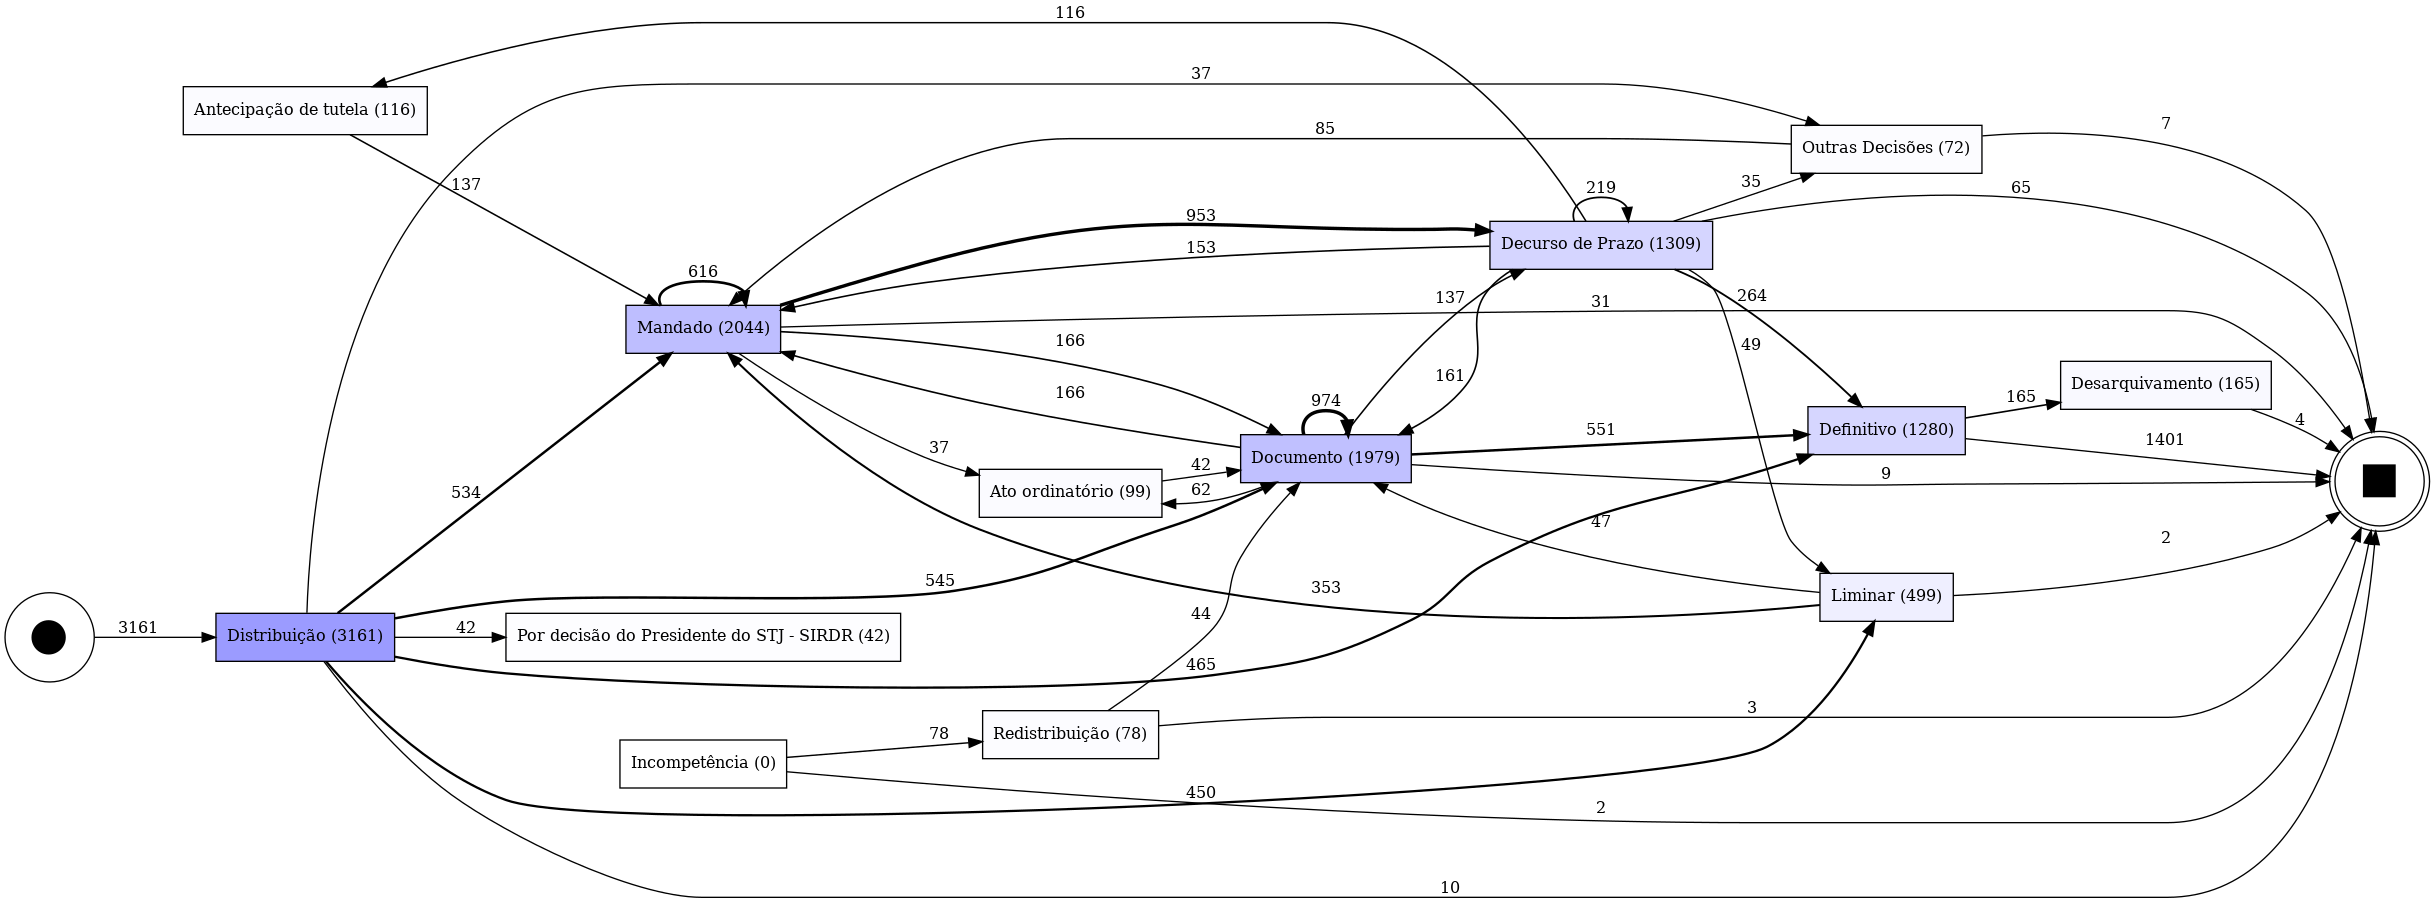

In [168]:
remove_list = [x[0] for x in most_frequent]
filtered_df = df.filter(~pl.col(ACTIVITY_NAME).is_in(remove_list))

show_flowchart(filtered_df, ea_dfg, sa_dfg)